<a href="https://colab.research.google.com/github/Ignas12345/Project_in_Computational_Biology/blob/main/After_Edges_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This part re-does the upscaling, but now with regularizaion from the underfitted "edge map".**

In [1]:
"""
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
!git clone https://github.com/Nikronic/EdgeNet.git
!git clone https://github.com/Ignas12345/Project_in_Computational_Biology.git

Cloning into 'EdgeNet'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 127 (delta 2), reused 4 (delta 1), pack-reused 121
Receiving objects: 100% (127/127), 808.96 KiB | 2.55 MiB/s, done.
Resolving deltas: 100% (72/72), done.
Cloning into 'Project_in_Computational_Biology'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 138 (delta 19), reused 0 (delta 0), pack-reused 78
Receiving objects: 100% (138/138), 19.65 MiB | 11.69 MiB/s, done.
Resolving deltas: 100% (46/46), done.


# Import libs

In [2]:
from Project_in_Computational_Biology.models import *
from PIL import Image
from Project_in_Computational_Biology.plotting import plot
from Project_in_Computational_Biology.converters import turn_to_grayscale, image_to_tensor, tensor_to_image, generate_noise

import torch
import torch.optim
from Project_in_Computational_Biology.models.downsampler import Downsampler
from EdgeNet.EdgeNet import EdgeNet

from Project_in_Computational_Biology.utils.sr_utils import *

#comment the following three lines if running on CPU

#torch.backends.cudnn.enabled = True
#torch.backends.cudnn.benchmark =True
#dtype = torch.cuda.FloatTensor

#and uncomment this line
dtype = torch.FloatTensor

upscaling_factor = 8

# Load image

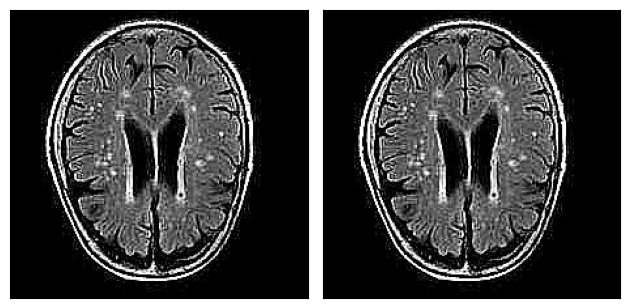

In [3]:
orig_img = Image.open('Project_in_Computational_Biology/pictures/Low_resolution_MRI.jpg')
gray_img = turn_to_grayscale(orig_img)
plot([orig_img, gray_img], cmap='gray') #Since both are exactly the same, we will use the grayscale version for speed and less complexity

# Set up parameters and net

In [4]:
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

num_iter = 4000
reg_noise_std = 0.05

In [5]:
net_image = generate_noise(gray_img, upscaling_factor)

In [6]:
net_input = image_to_tensor(net_image).type(dtype).detach()

In [7]:
NET_TYPE = 'skip' # UNet, ResNet
net = skip(
        num_input_channels=1, num_output_channels=1,
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4],
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True,
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU',
        need1x1_up=True).type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = image_to_tensor(gray_img).type(dtype)

downsampler = Downsampler(n_planes=1, factor=upscaling_factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

# Define closure and optimize

In [12]:
underfitted_edges = image_to_tensor(Image.open('underfitted_edges.jpg')).type(dtype)

In [21]:
underfitted_edges_img = Image.open('underfitted_edges.jpg')
underfitted_edges = image_to_tensor(underfitted_edges_img).type(dtype)
underfitted_edges_LR = downsampler(underfitted_edges).type(dtype).detach()
underfitted_edges_img_LR = tensor_to_image(underfitted_edges_LR)

In [9]:
edgenet = EdgeNet(input_channels = 1).type(dtype)
#Here you can choose which parameters of EdgeNet You want to use. Each can give different results. It becomes like a sort of game at this point...
edgenet.load_state_dict(torch.load('Project_in_Computational_Biology/EdgeNet_parameters/model_parameters_6'))

<All keys matched successfully>

In [10]:
def closure():
    global i, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)
    edges = edgenet(out_LR) #this can either be LR or HR. If LR, make sure that the underfitted edges image is downscaled via downsampler

    total_loss = mse(out_LR, img_LR_var)  + 0.5 * mse(edges, underfitted_edges_LR)
    total_loss.backward()
    print('iteration: ' + str(i))

    if i % 25 == 0:
      output_img = tensor_to_image(out_HR)
      plot([gray_img, output_img], cmap = 'gray')
      output_img.save('High_resolution_iteration_after_edges' + str(i) + '.jpg')

    i += 1

    return total_loss

In [20]:
def closure():
    global i, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)
    edges = edgenet(out_LR)

    total_loss = mse(out_LR, img_LR_var)  + 0.5 * mse(edges, underfitted_edges)
    total_loss.backward()
    print('iteration: ' + str(i))

    if i % 25 == 0:
      output_img = tensor_to_image(out_HR)
      plot([gray_img, output_img], cmap = 'gray')
      output_img.save('High_resolution_iteration_after_edges' + str(i) + '.jpg')

    i += 1

    return total_loss

Starting optimization with ADAM
iteration: 0


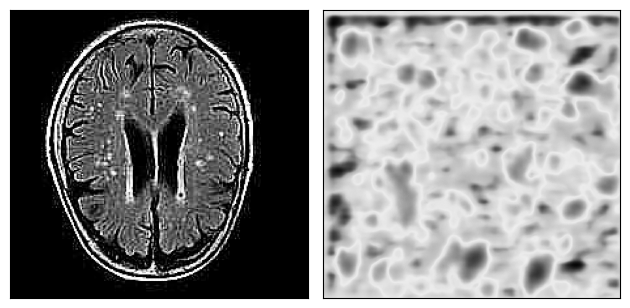

iteration: 1
iteration: 2
iteration: 3
iteration: 4


KeyboardInterrupt: 

In [19]:
psnr_history = []
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

**As you can see, we start recovering the noise as the number of iterations grows. We want to somehow avoid that.**